# Analysis for the the one with curriculum learning

In [1]:
import tbparse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# For the training

In [2]:
from tbparse import SummaryReader
Gen_ARL_train = r"../../TrainerConfig/results/Curr42d/Generator/"
Solver_ARL_train = r"../../TrainerConfig/results/Curr42d/Solver/"
reader_gen = SummaryReader(Gen_ARL_train)
reader_solver = SummaryReader(Solver_ARL_train)
df_solver = reader_solver.scalars
df_gen = reader_gen.scalars
pd.unique(df_gen["tag"])
# df_gen.head()
# df_gen

array(['Environment/Cumulative Reward', 'Environment/Episode Length',
       'Environment/Lesson Number/aux_input',
       'Environment/Lesson Number/n_obstacles',
       'Losses/Curiosity Forward Loss', 'Losses/Curiosity Inverse Loss',
       'Losses/Policy Loss', 'Losses/Value Loss', 'Policy/Beta',
       'Policy/Curiosity Reward', 'Policy/Curiosity Value Estimate',
       'Policy/Entropy', 'Policy/Epsilon', 'Policy/Extrinsic Reward',
       'Policy/Extrinsic Value Estimate', 'Policy/Learning Rate', 'Score',
       'Y_difference', 'distance', 'height', 'theta'], dtype=object)

In [3]:
df_gen

,step,tag,value
0,1000,Environment/Cumulative Reward,1.182363
1,2000,Environment/Cumulative Reward,1.892153
2,3000,Environment/Cumulative Reward,3.627184
3,4000,Environment/Cumulative Reward,4.152931
4,5000,Environment/Cumulative Reward,5.583900
...,...,...,...
5742,366000,theta,-0.038249
5743,367000,theta,0.992048
5744,368000,theta,1.707731
5745,369000,theta,-0.894614


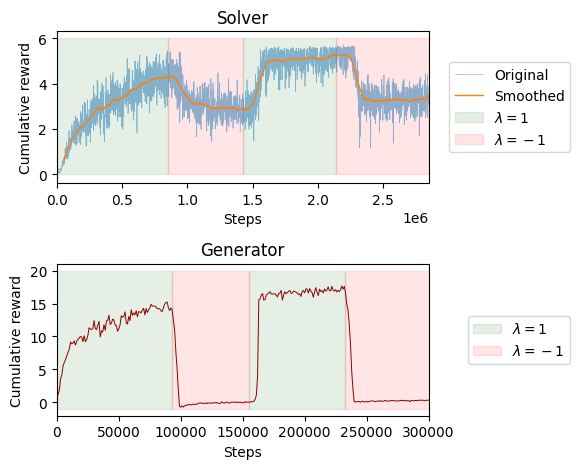

In [4]:
auxs = [0, .3, .5, .75, 1]
solver_cum_pd = df_solver.loc[df_solver["tag"]=="Environment/Cumulative Reward", ["step", "value"]]
ax1 = plt.subplot(2,1,1)

maxstep = 2.85e6
#  Generator
kwards = {'x':"step", 'y':"value", "kind":"line"}
solver_cum_pd.plot(**kwards, linewidth=.5, ax=ax1, alpha=.5, label="Original")
#  Smoothed version
solver_cum_pd.rolling(100).mean().plot(**kwards, linewidth=1, ax=ax1, label="Smoothed")
ax1.set_xlabel("Steps")
ax1.set_ylabel("Cumulative reward")
ax1.set_xlim(0, maxstep)
ax1.set_title("Solver")
fill_args = {'alpha':0.1}
ymax = 6
# Regions
ax1.fill_betweenx([0,ymax],auxs[0]*maxstep,auxs[1]*maxstep, color='darkgreen', **fill_args,
                  label=r"$\lambda=1$")
ax1.fill_betweenx([0,ymax],auxs[1]*maxstep,auxs[2]*maxstep, color='red', **fill_args,
                  label=r"$\lambda=-1$")
ax1.fill_betweenx([0,ymax],auxs[2]*maxstep,auxs[3]*maxstep, color='darkgreen', **fill_args)
ax1.fill_betweenx([0,ymax],auxs[3]*maxstep,auxs[4]*maxstep, color='red', **fill_args)
ax1.legend(loc='center right',bbox_to_anchor=(1.4,.5))

# Solver
maxstep = 3.1e5
ymax=20
ymin=-1
# Solver
ax2 = plt.subplot(2,1,2)
gen_cum_pd = df_gen.loc[df_gen["tag"]=="Environment/Cumulative Reward", ["step", "value"]]
gen_cum_pd.plot(**kwards, ax=ax2, color='darkred', linewidth=.7, label="")
ax2.set_xlabel("Steps")
ax2.set_ylabel("Cumulative reward")
ax2.set_xlim(0, 3e5)
# ax2.legend("", frameon=False)
ax2.set_title("Generator")
# Regions
ax2.fill_betweenx([ymin,ymax],auxs[0]*maxstep,auxs[1]*maxstep, color='darkgreen', **fill_args,
                  label=r"$\lambda=1$")
ax2.fill_betweenx([ymin,ymax],auxs[1]*maxstep,auxs[2]*maxstep, color='red', **fill_args,
                  label=r"$\lambda=-1$")
ax2.fill_betweenx([ymin,ymax],auxs[2]*maxstep,auxs[3]*maxstep, color='darkgreen', **fill_args)
ax2.fill_betweenx([ymin,ymax],auxs[3]*maxstep,auxs[4]*maxstep, color='red', **fill_args)
ax2.legend(loc='center right',bbox_to_anchor=(1.4,.5))
plt.tight_layout()
# plt.savefig("images/Cumm_reward_Curr42d.pdf")

# For test

In [5]:
from tbparse import SummaryReader

In [32]:
# Get the scores datas from tensorboard events if the events are separated for each aux input
# Needs the tbparse module
def get_score(path, aux_input, step_start=100000):
    reader = SummaryReader(path)
    dfScore = reader.scalars
    Score = dfScore.loc[dfScore["tag"]=='Score',['step', 'value']]
    Score.rename(columns = {'value':'Score'}, inplace=True)
    Score["aux_input"] = aux_input
    Score = Score.loc[Score['step'] > step_start,:]
    return Score

# Get the scores datas from tensorboard events if the events are combined for all aux inputs
# Needs the tbparse module
def get_score_combined(path, step_end=5e6):
    reader = SummaryReader(path)
    dfScore = reader.scalars
    # One big Dataframe for all the aux_input
    Score = dfScore.loc[dfScore["tag"]=='Score',['step', 'value']]
    Score.rename(columns = {'value':'Score'}, inplace=True)
    auxs = [1, 0.5, 0, -0.5, -1] # order of the aux input in the event file, changes every 1e6 steps
    
    Score["aux_input"] = 1
    Scores = dict() # A dictionary of Dataframe
    # Set the aux_input column for the corresponding steps
    for i, au in enumerate(auxs):
        # assign an aux_input for the big DataFrame
        Score.loc[Score["step"] > 1e6*i, "aux_input"] = au
        #Assign one dataFrame for each aux_input
        Scores[au] = Score.loc[Score["step"] > 1e6*i, ]
        
    Score = Score.loc[Score['step'] <= step_end,]
    return Score, Scores

In [33]:
ARL  = dict()
PCG  = dict()
PCG_Const = dict()
fixed = dict()
for aux in [1, 0.5, 0, -0.5, -1]:
    path_ARL = f"../../TrainerConfig/results/InferCurr42d_{aux}/Solver/"
    ARL[aux] = get_score(path_ARL, aux)
    
    path_PCG = f"../../TrainerConfig/results/InferPCG_2_aux_{aux}/Solver/"
    PCG[aux] = get_score(path_PCG, aux)
    
    path_constPCG = f"../../TrainerConfig/results/InferPCG_Const_1_aux_{aux}/Solver/"
    PCG_Const[aux] = get_score(path_constPCG, aux)
    
# the data of fixed environment was outputed on the same event for all the aux_input    
path_fixed = f"../../TrainerConfig/results/InferFixed_2/Solver"
_, fixed = get_score_combined(path_fixed)

### Box plot of the scores for ARLPCG

Text(0.5, 1.0, '')

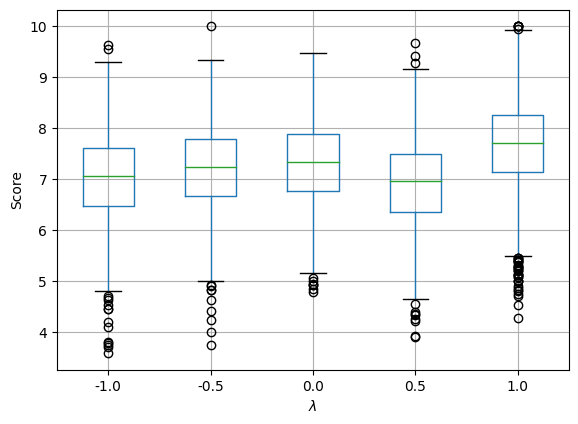

In [34]:
ARLs = pd.concat([ARL[d] for d in ARL]) # Combine the DataFrames
grouped = ARLs.groupby('aux_input')
fig = plt.figure()
ax = fig.gca()
ax.grid()
# bp = grouped.boxplot(column=["Score"], subplots=False, ax=ax)
ARLs.loc[:,["Score", "aux_input"]].boxplot(by="aux_input", ax=ax)
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel("Score")
plt.suptitle("")
plt.title("")

In [35]:
def boxplots(df_dict, suptitle="", title="", ax=None, **kwargs):
    df_dicts = pd.concat([df_dict[d] for d in df_dict]) # Combine the DataFrames
    grouped = df_dicts.groupby('aux_input')
    
    # new figure
    if(ax == None):
        fig = plt.figure()
        ax = fig.gca()
        ax.grid()
    
    # box plot by aux_input
    df_dicts.loc[:,["Score", "aux_input"]].boxplot(by="aux_input", ax=ax, **kwargs)
    ax.set_xlabel(r"$\lambda$")
    ax.set_ylabel("Score")
#     ax.suptitle.set_text(suptitle)
    ax.title.set_text(title)

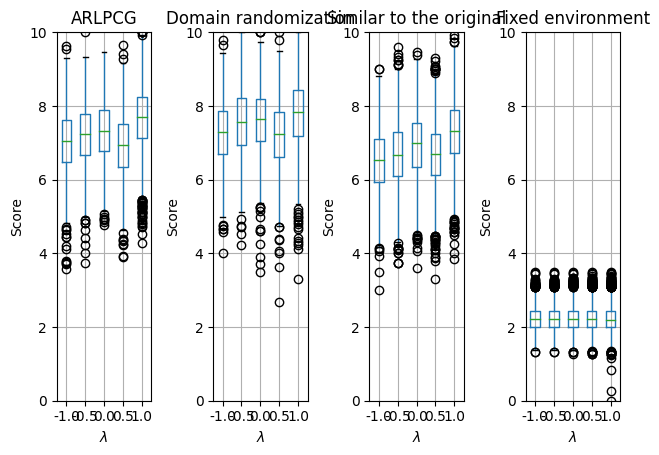

In [38]:
n = 4
fig = plt.figure()
axs = []
[axs.append(plt.subplot(1,n,i)) for i in range(1,n+1)]
# axs.append(plt.subplot(1,3,1))
# axs.append(plt.subplot(1,3,2))
# axs.append(plt.subplot(1,3,3))

for ax in axs:
    ax.set_ylim(0,10)

boxplots(ARL, ax=axs[0], title="ARLPCG")
boxplots(PCG, ax=axs[1], title="Domain randomization")
boxplots(PCG_Const, ax=axs[2], title="Similar to the original")
boxplots(fixed, ax=axs[3], title="Fixed environment")
plt.suptitle("")
plt.tight_layout()

In [39]:
PCG_Const[1].mean()

step         1.643000e+06
Score        7.290867e+00
aux_input    1.000000e+00
dtype: float64

In [40]:
PCG[1].mean()

step         695500.000000
Score             7.771889
aux_input         1.000000
dtype: float64

In [41]:
ARL[1].mean()

step         1.555500e+06
Score        7.671879e+00
aux_input    1.000000e+00
dtype: float64

In [49]:
def means(df_list, tag="Score"):
    value = []
    for d in df_list:
        value.append(d[tag].mean())
    return np.array(value)
    
def medians(df_list, tag="Score"):
    value = []
    for d in df_list:
        value.append(d[tag].median())
    return np.array(value)

def std(df_list, tag="Score"):
    value = []
    for d in df_list:
        value.append(d[tag].std())
    return np.array(value)

def ratio(df, aux, average_method = "mean"):
    if(average_method == "mean"):
        return df[aux]["Score"].mean() / 10
    elif(average_method == "median"):
        return df[aux]["Score"].median() / 10
    else:
        return df[aux]["Score"].mean() / 10
    
def ratioWithStd(df, aux, average_method = "mean"):
    std = df[aux]["Score"].std() / 10
    if(average_method == "mean"):
        av = df[aux]["Score"].mean() / 10
        return f"{av:.4f}$\pm${std:.3f}"
    elif(average_method == "median"):
        av = df[aux]["Score"].median() / 10
        return f"{av:.4f}$\pm${std:.3f}"

# Solving ratio without error

In [45]:
aux_list = [-1, -.5, 0, .5, 1]
models = ["ARLPCG", "Domain randomization", "Original game", "Fixed environment"]
descr = dict()

# Create a table of the solving ratio
descr[models[0]] = {aux:ratio(ARL, aux) for aux in aux_list} #ARLPCG
descr[models[1]] = {aux:ratio(PCG, aux) for aux in aux_list} #PCG
descr[models[2]] = {aux: ratio(PCG_Const, aux) for aux in aux_list} #Const PCG
descr[models[3]] = {aux: ratio(fixed, aux) for aux in aux_list} # fixed

In [46]:
pd.DataFrame(descr)

,ARLPCG,Domain randomization,Original game,Fixed environment
-1.0,0.701536,0.726023,0.650781,0.222627
-0.5,0.719238,0.753503,0.667705,0.222340
0.0,0.730316,0.758374,0.693358,0.222260
0.5,0.691243,0.719080,0.667566,0.222111
1.0,0.767188,0.777189,0.729087,0.221891


In [17]:
descr1 = dict()

# Create a table of the solving ratio
descr1[models[0]] = {aux:ratio(ARL, aux, average_method='median') for aux in aux_list} #ARLPCG
descr1[models[1]] = {aux:ratio(PCG, aux, average_method='median') for aux in aux_list} #PCG
descr1[models[2]] = {aux: ratio(PCG_Const, aux,  average_method='median') for aux in aux_list} #Const PCG

pd.DataFrame(descr1)

,ARLPCG,PCG,Const PCG
-1.0,0.705556,0.728175,0.653137
-0.5,0.723529,0.755556,0.666667
0.0,0.733333,0.764286,0.700000
0.5,0.695346,0.723077,0.670588
1.0,0.771429,0.784615,0.733333


# Solving ratio with errors

In [50]:
aux_list = [-1, -.5, 0, .5, 1]
models = ["ARLPCG", "Domain randomization", "Original game", "Fixed environment"]
descrE = dict()

# Create a table of the solving ratio
descrE[models[0]] = {aux:ratioWithStd(ARL, aux) for aux in aux_list} #ARLPCG
descrE[models[1]] = {aux:ratioWithStd(PCG, aux) for aux in aux_list} #PCG
descrE[models[2]] = {aux: ratioWithStd(PCG_Const, aux) for aux in aux_list} #Const PCG
descrE[models[3]] = {aux: ratioWithStd(fixed, aux) for aux in aux_list} # fixed
descrE = pd.DataFrame(descrE)

# Rename the axis
descrE.rename_axis("$\lambda$", axis=1, inplace=True)

In [53]:
descrE

$\lambda$,ARLPCG,Domain randomization,Original game,Fixed environment
-1.0,0.7015$\pm$0.087,0.7260$\pm$0.087,0.6508$\pm$0.089,0.2226$\pm$0.033
-0.5,0.7192$\pm$0.082,0.7535$\pm$0.093,0.6677$\pm$0.094,0.2223$\pm$0.033
0.0,0.7303$\pm$0.084,0.7584$\pm$0.091,0.6934$\pm$0.090,0.2223$\pm$0.033
0.5,0.6912$\pm$0.084,0.7191$\pm$0.092,0.6676$\pm$0.084,0.2221$\pm$0.033
1.0,0.7672$\pm$0.085,0.7772$\pm$0.098,0.7291$\pm$0.088,0.2219$\pm$0.033


In [54]:
print(descrE.to_latex())

\begin{tabular}{lllll}
\toprule
$\lambda$ & ARLPCG & Domain randomization & Original game & Fixed environment \\
\midrule
-1.000000 & 0.7015$\pm$0.087 & 0.7260$\pm$0.087 & 0.6508$\pm$0.089 & 0.2226$\pm$0.033 \\
-0.500000 & 0.7192$\pm$0.082 & 0.7535$\pm$0.093 & 0.6677$\pm$0.094 & 0.2223$\pm$0.033 \\
0.000000 & 0.7303$\pm$0.084 & 0.7584$\pm$0.091 & 0.6934$\pm$0.090 & 0.2223$\pm$0.033 \\
0.500000 & 0.6912$\pm$0.084 & 0.7191$\pm$0.092 & 0.6676$\pm$0.084 & 0.2221$\pm$0.033 \\
1.000000 & 0.7672$\pm$0.085 & 0.7772$\pm$0.098 & 0.7291$\pm$0.088 & 0.2219$\pm$0.033 \\
\bottomrule
\end{tabular}

